# Trajectory Analysis using 10x Single Cell Gene Expression Data
More details on this analysis can be found in the 10x Genomics Analysis Guides tutorial, located here: https://www.10xgenomics.com/resources/analysis-guides/trajectory-analysis-using-10x-Genomics-single-cell-gene-expression-data

September 14, 2023

This will install the required Python library packages needed for this tutorial:

In [1]:
!pip install numpy==1.23 pandas==1.5.3 matplotlib==3.6.0 scanpy==1.9.1 igraph==0.9.8 scvelo==0.2.4 loompy==3.0.6 anndata==0.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 90.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 100.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 99.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 57.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 43.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.3/196.3 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 7.4 MB/s eta 0:00:0000:0100:01mm
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 

This will create a new directory called "input-files", then download and extract several input data files needed for this tutorial, then display the list of files now available.

In [2]:
!mkdir input-files
!curl -o input-files/filtered_feature_bc_matrix.tar.gz https://cf.10xgenomics.com/supp/cell-exp/neutrophils/filtered_feature_bc_matrix.tar.gz
!curl -o input-files/WB_Lysis_3p_Introns_8kCells.loom https://cf.10xgenomics.com/supp/cell-exp/neutrophils/WB_Lysis_3p_Introns_8kCells.loom
!curl -o input-files/3p-Neutrophils-clusters.csv https://cf.10xgenomics.com/supp/cell-exp/neutrophils/3p-Neutrophils-clusters.csv
!curl -o input-files/3p-Neutrophils-UMAP-Projection.csv https://cf.10xgenomics.com/supp/cell-exp/neutrophils/3p-Neutrophils-UMAP-Projection.csv
!tar -xvzf input-files/filtered_feature_bc_matrix.tar.gz -C input-files/
!ls -lah input-files

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.2M  100 16.2M    0     0  11.9M      0  0:00:01  0:00:01 --:--:-- 11.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67.5M  100 67.5M    0     0  54.9M      0  0:00:01  0:00:01 --:--:-- 54.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 96967  100 96967    0     0   150k      0 --:--:-- --:--:-- --:--:--  150k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  185k  100  185k    0     0   434k      0 --:--:-- --:--:-- --:--:--  434k
filtered_feature_bc_matrix/
filtered_feature_bc_matr

In [3]:
# First, import required packages in the current session.

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
import igraph
import scvelo as scv
import loompy as lmp
import anndata

import warnings
warnings.filterwarnings('ignore')

* The scvelo tool only calculates velocity
* Now we need anchors for visualization
* UMAP gives us projections
* barcode assignments are associated with different clusters
* UMAP + clusters come from Loupe

Let's import the 2 files from Loupe.

In [4]:
# Read in the subset of clusters exported from Loupe Browser
Clusters_Loupe = pd.read_csv("./input-files/3p-Neutrophils-clusters.csv", delimiter=',',index_col=0)

# Create list with only Neutrophil Barcodes
# This will be used later to subset the count matrix
Neutrophils_BCs = Clusters_Loupe.index

In [5]:
# Read UMAP exported from Loupe Browser
UMAP_Loupe = pd.read_csv("./input-files/3p-Neutrophils-UMAP-Projection.csv", delimiter=',',index_col=0)

# Tansform to Numpy (for formatting)
UMAP_Loupe = UMAP_Loupe.to_numpy()

Now we will import the GEX matrix.



In [6]:
# Define Path to cellranger output
Path10x='./input-files/filtered_feature_bc_matrix/'

# Read filtered feature bc matrix output from cellranger count
Neutro3p = sc.read_10x_mtx(Path10x,var_names='gene_symbols',cache=True)
Neutro3p

AnnData object with n_obs × n_vars = 8000 × 36601
    var: 'gene_ids', 'feature_types'

In [7]:
# These are the barcodes (n_obs) = 8000
# This is the number set in --force-cells
Neutro3p.obs

""
AAACCCAAGGCACTCC-1
AAACCCACAACTCCCT-1
AAACCCAGTACGAGCA-1
AAACCCAGTTGTGCAT-1
AAACCCATCTTCGGAA-1
...
TTTGTTGTCGCTACAA-1
TTTGTTGTCGTCAGAT-1
TTTGTTGTCTACTTCA-1
TTTGTTGTCTTAGCAG-1


In [8]:
# These are the gene_ids (n_vars) = 36,601
Neutro3p.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [9]:
Neutro3p_df = Neutro3p.to_df()
Neutro3p_df.head()

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
AAACCCAAGGCACTCC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCACAACTCCCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAGTACGAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCAGTTGTGCAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCCATCTTCGGAA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The earlier matrix was the full dataset.
But we are only interested in neutrophils. So, we need to subset the matrix into only neutrophils
First, we need to define which barcodes are associated with which cluster

In [10]:
# Filter Cells to only Neutrophils
Neutro3p = Neutro3p[Neutrophils_BCs]

# Add Clusters from Loupe to object
Neutro3p.obs['Loupe'] = Clusters_Loupe

# Add UMAP from Loupe to object
Neutro3p.obsm["X_umap"] = UMAP_Loupe

You might get this warning below, but nothing to worry about.
> Trying to set attribute `.obs` of view, copying.

Next, read velocyto output and merge

In [11]:
# Read velocyto output
VelNeutro3p = scv.read('./input-files/WB_Lysis_3p_Introns_8kCells.loom', cache=True)

# Merge velocyto and cellranger outputs
Neutro3p = scv.utils.merge(Neutro3p, VelNeutro3p)

Neutro3p

AnnData object with n_obs × n_vars = 3343 × 36601
    obs: 'Loupe', 'Clusters', '_X', '_Y', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

You might get this warning, but no need to worry:
> Variable names are not unique. To make them unique, call `.var_names_make_unique`.

Next, process dataset and obtain latent time values for each cell


In [12]:
# Standard scvelo processing to run Dynamical Mode
scv.pp.filter_and_normalize(Neutro3p, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(Neutro3p, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(Neutro3p)
scv.tl.velocity(Neutro3p, mode='dynamical')
scv.tl.velocity_graph(Neutro3p)
scv.tl.recover_latent_time(Neutro3p)

Neutro3p

Filtered out 35468 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/224 cores)


  0%|          | 0/67 [00:00<?, ?gene/s]

    finished (0:00:23) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/224 cores)


  0%|          | 0/3343 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 5 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


AnnData object with n_obs × n_vars = 3343 × 1133
    obs: 'Loupe', 'Clusters', '_X', '_Y', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_ids', 'feature_types', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'pca', 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs', 'loss'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scVelo-umap-cluster.png


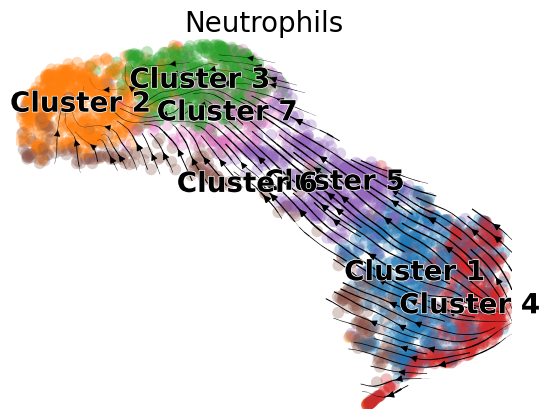

In [13]:
# velocity plo
# default plotting parameters
scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="Loupe",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2,save='scVelo-umap-cluster.png')

saving figure to file ./figures/scvelo_scVelo-umap-latent_time.png


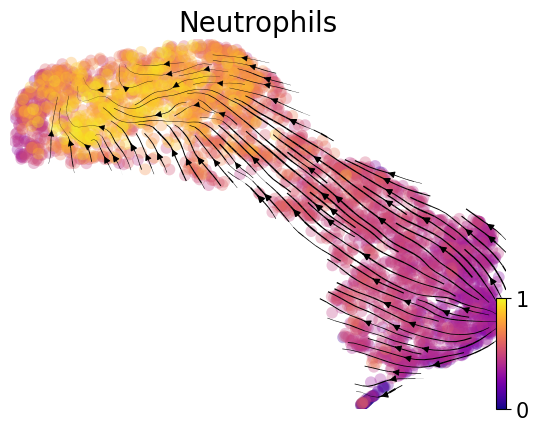

In [14]:
scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="latent_time",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2,color_map="plasma",save='scVelo-umap-latent_time.png')

saving figure to file ./figures/scvelo_heatmap_scVelo-heatmap-latent_time.png


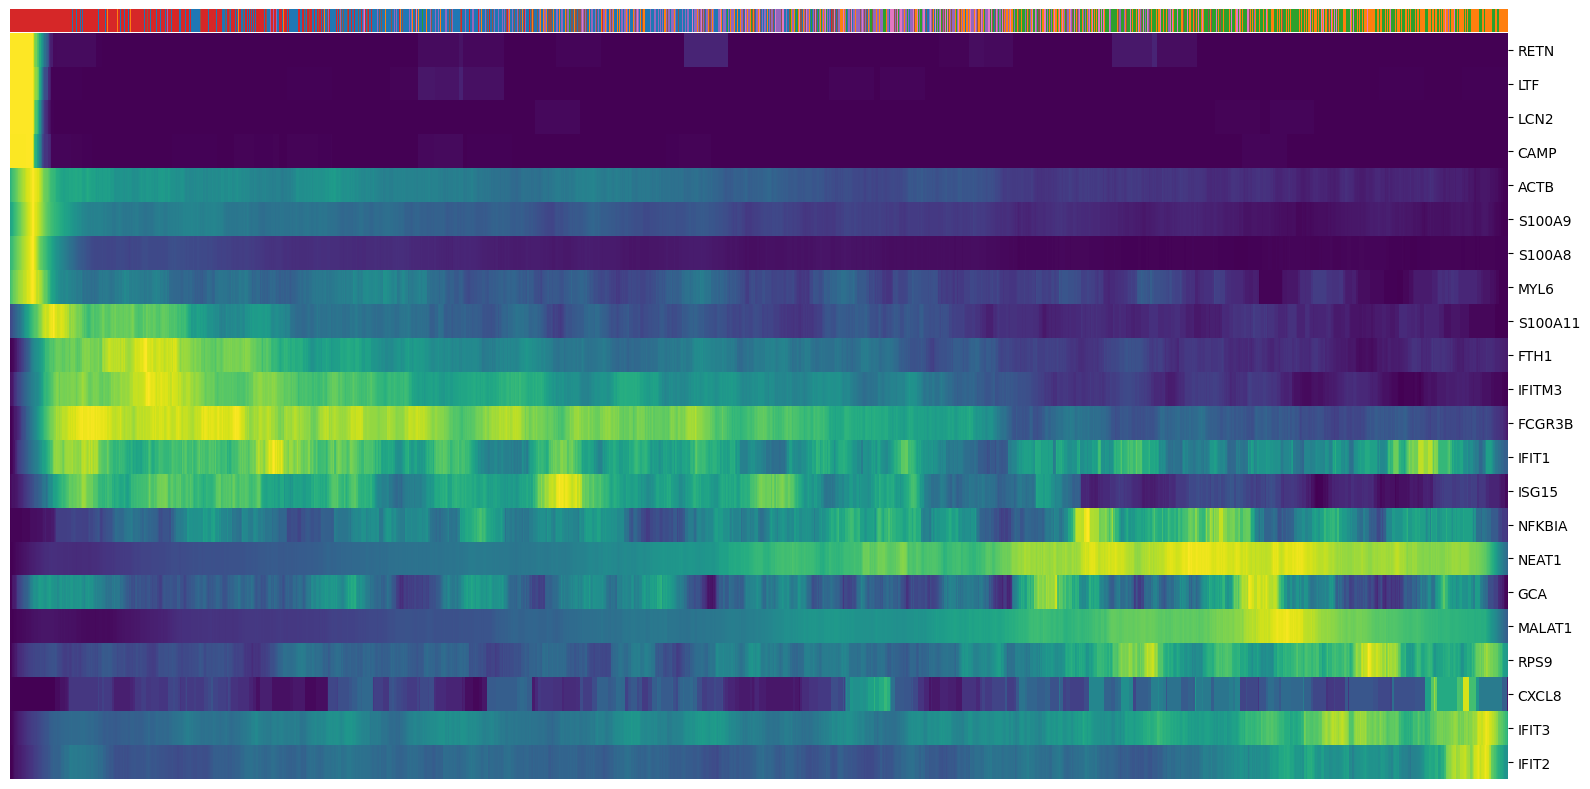

In [15]:
Genes=["RETN","LTF","CAMP","ACTB","GCA","LCN2",
         "S100A8","MYL6","S100A9","FCGR3B","S100A11","FTH1","IFIT1",
         "IFITM3","IFIT3","ISG15","IFIT2","RPS9","NEAT1","MALAT1","NFKBIA","CXCL8"]
scv.pl.heatmap(Neutro3p, var_names=Genes, sortby='latent_time', col_color='Loupe', n_convolve=100,figsize=(16,8),yticklabels=True,sort=True,colorbar=True,show=True,layer="count", save='scVelo-heatmap-latent_time.png')

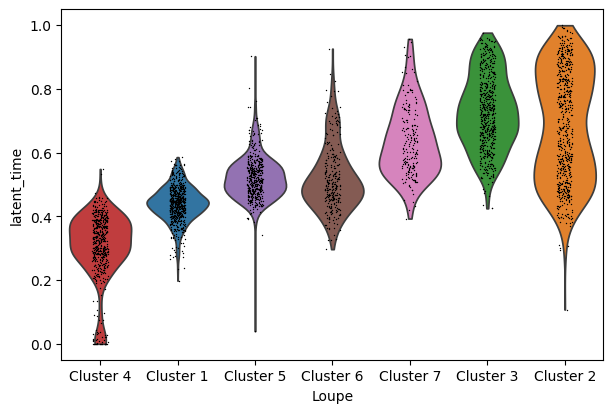

In [16]:
sc.pl.violin(Neutro3p, keys='latent_time',groupby="Loupe",order=["Cluster 4","Cluster 1","Cluster 5","Cluster 6","Cluster 7","Cluster 3","Cluster 2"], save='scVelo-violin-latent_time.png')

This chunk of code below is used to customize colors for the cluster and plot sizes

In [17]:
# Customize parameters for plots (Size, Color, etc)
# let's set these to improve our plots
scv.set_figure_params(style="scvelo")
pl.rcParams["figure.figsize"] = (10,10)
Colorss=["#E41A1C","#377EB8","#4DAF4A","#984EA3","#FF7F00","#FFFF33","#A65628","#F781BF"]

saving figure to file ./figures/scvelo_scVelo-umap-cluster.png


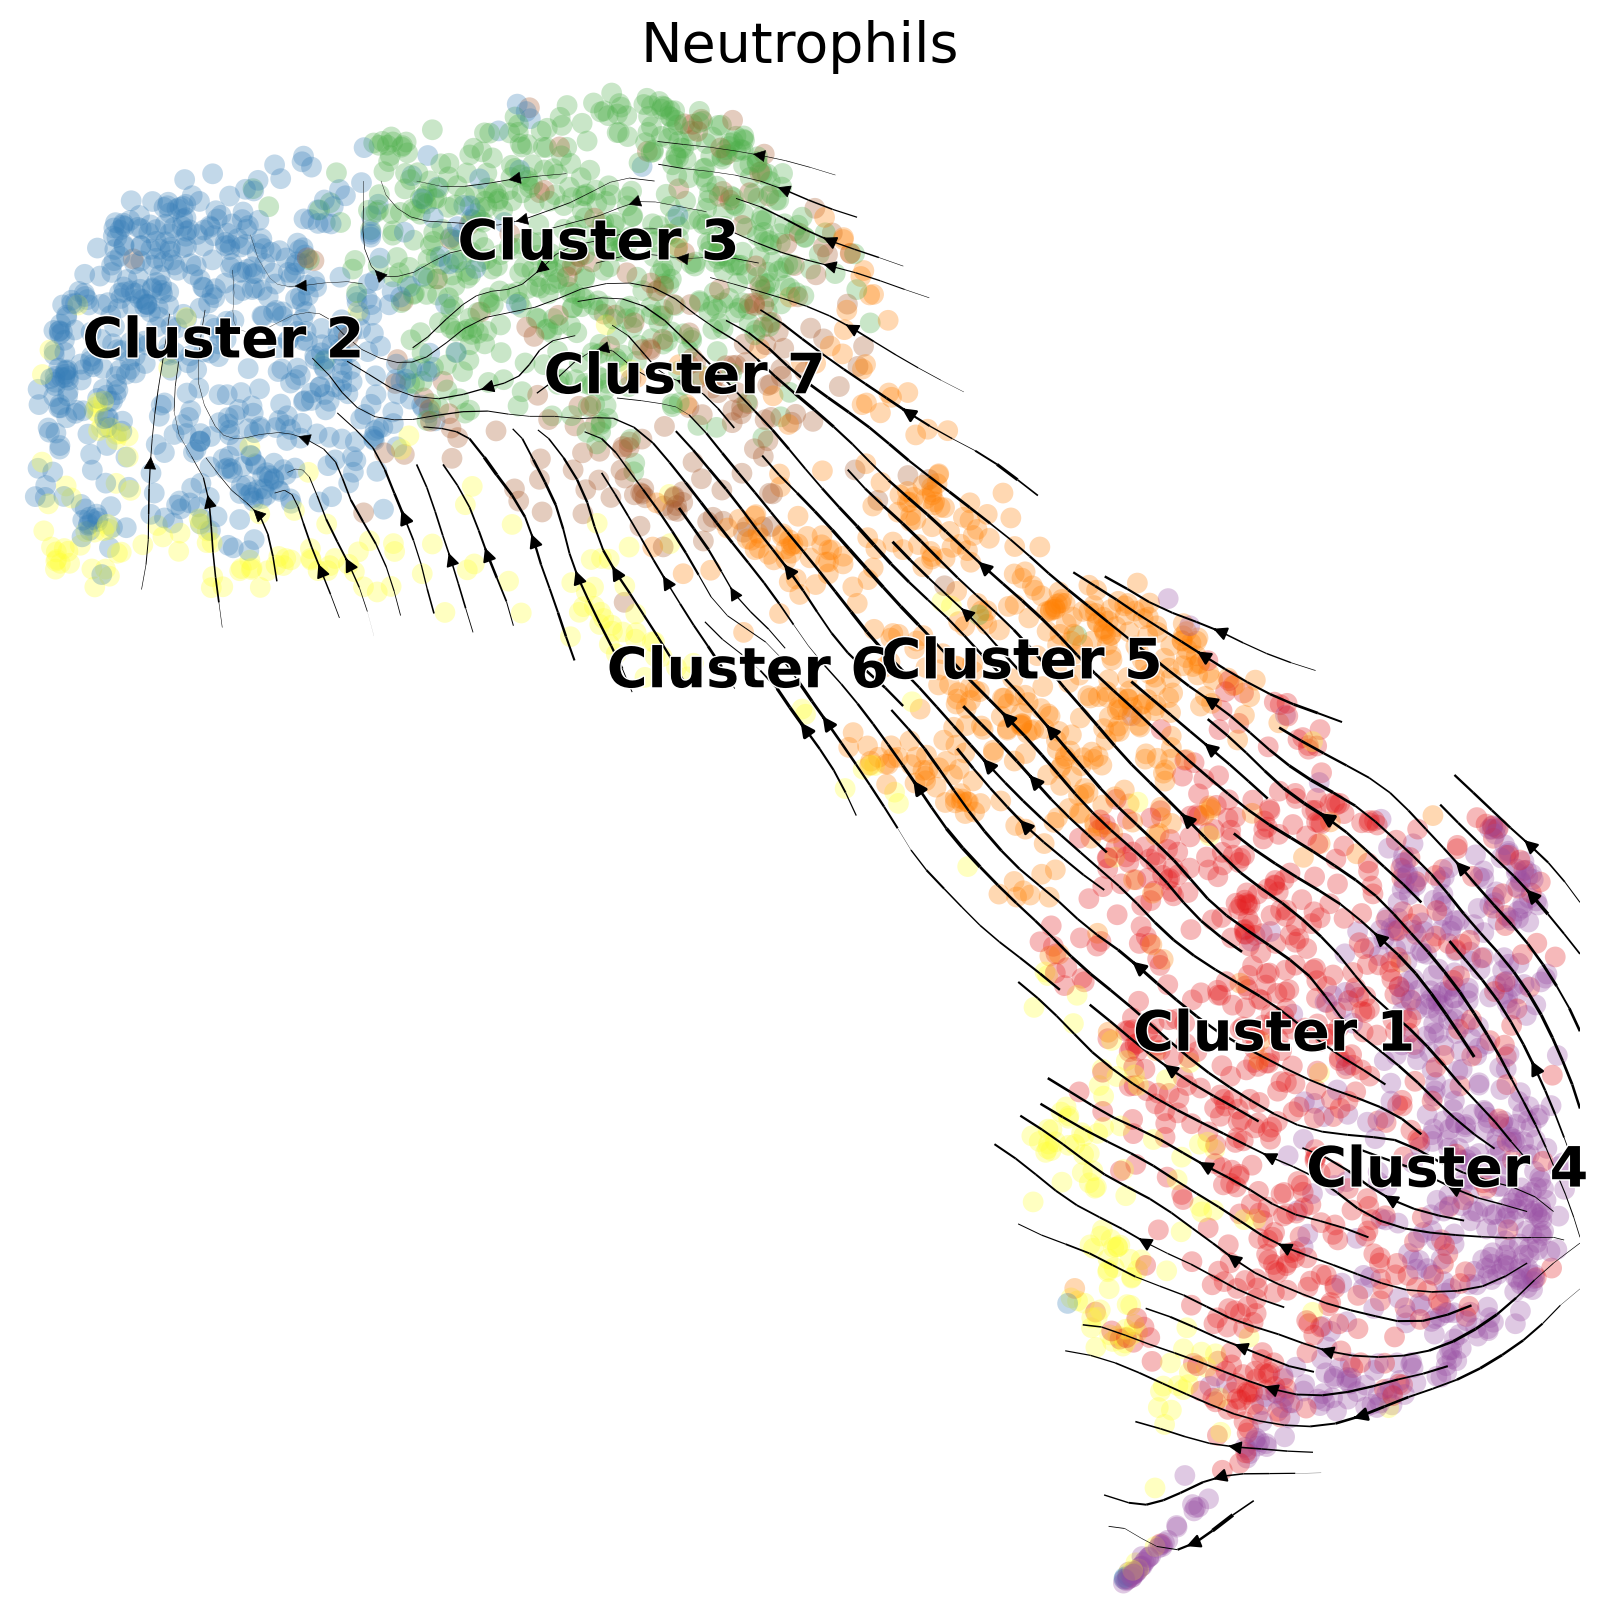

In [18]:
scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="Loupe",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2,palette=Colorss,save='scVelo-umap-cluster.png')

saving figure to file ./figures/scvelo_scVelo-umap-latent_time.png


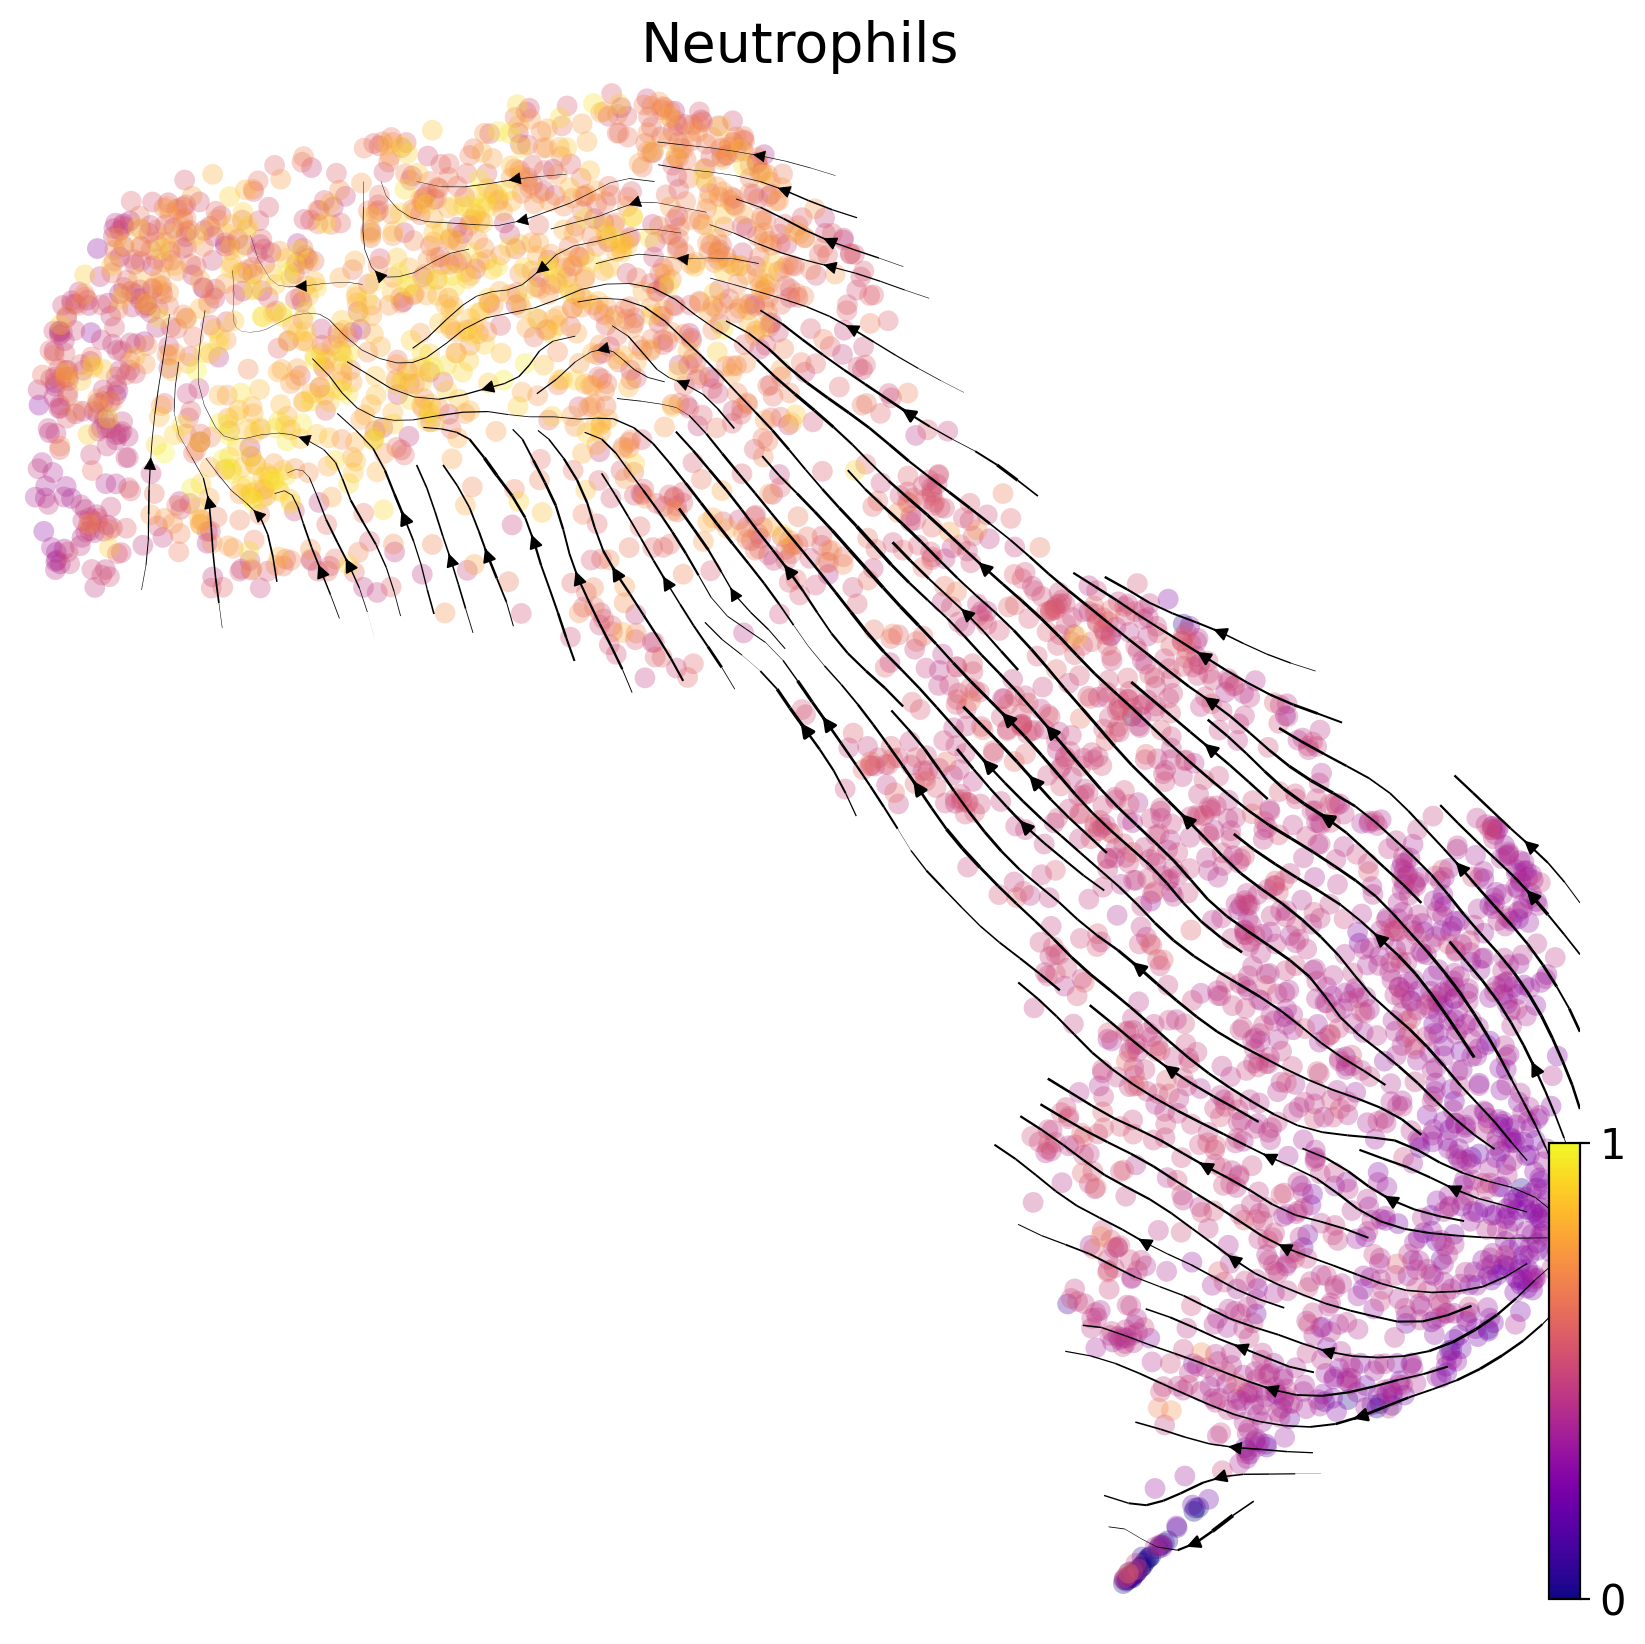

In [19]:
scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="latent_time",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2,color_map="plasma",save='scVelo-umap-latent_time.png')

saving figure to file ./figures/scvelo_heatmap_scVelo-heatmap-latent_time.png


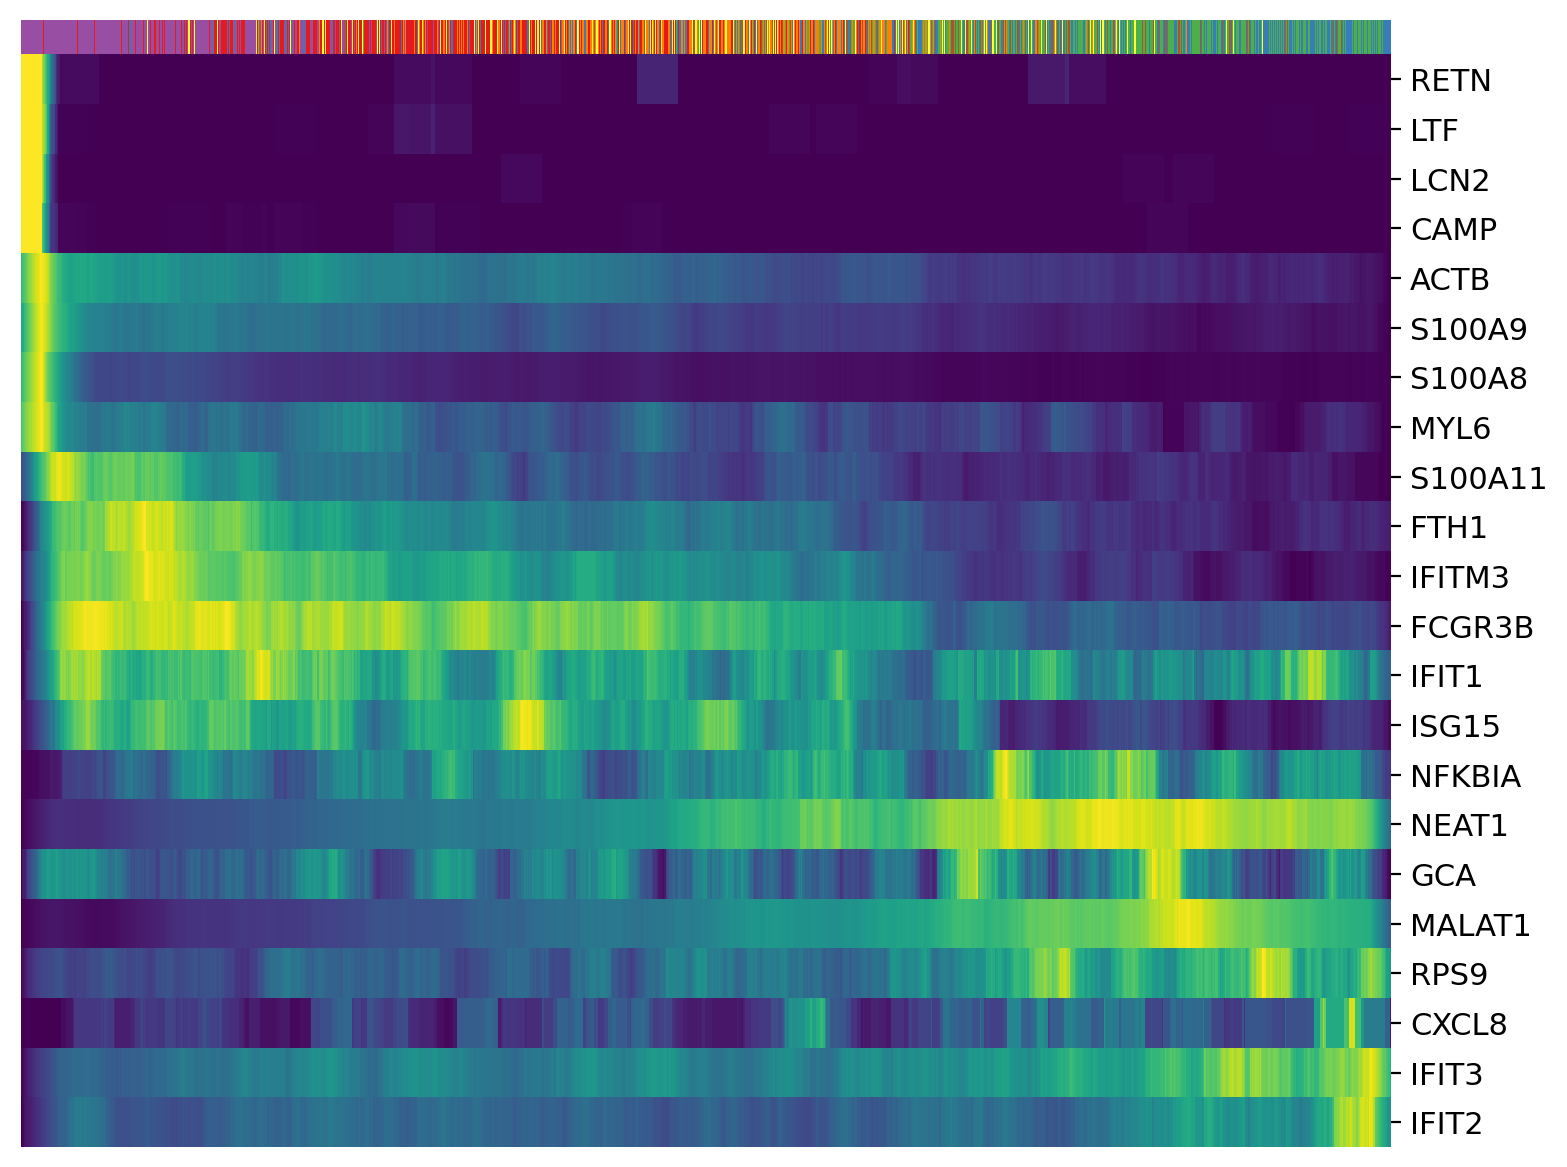

In [20]:
scv.pl.heatmap(Neutro3p, var_names=Genes, sortby='latent_time', col_color='Loupe', n_convolve=100,figsize=(8,6),yticklabels=True,sort=True,colorbar=True,show=True,layer="count", save='scVelo-heatmap-latent_time.png')

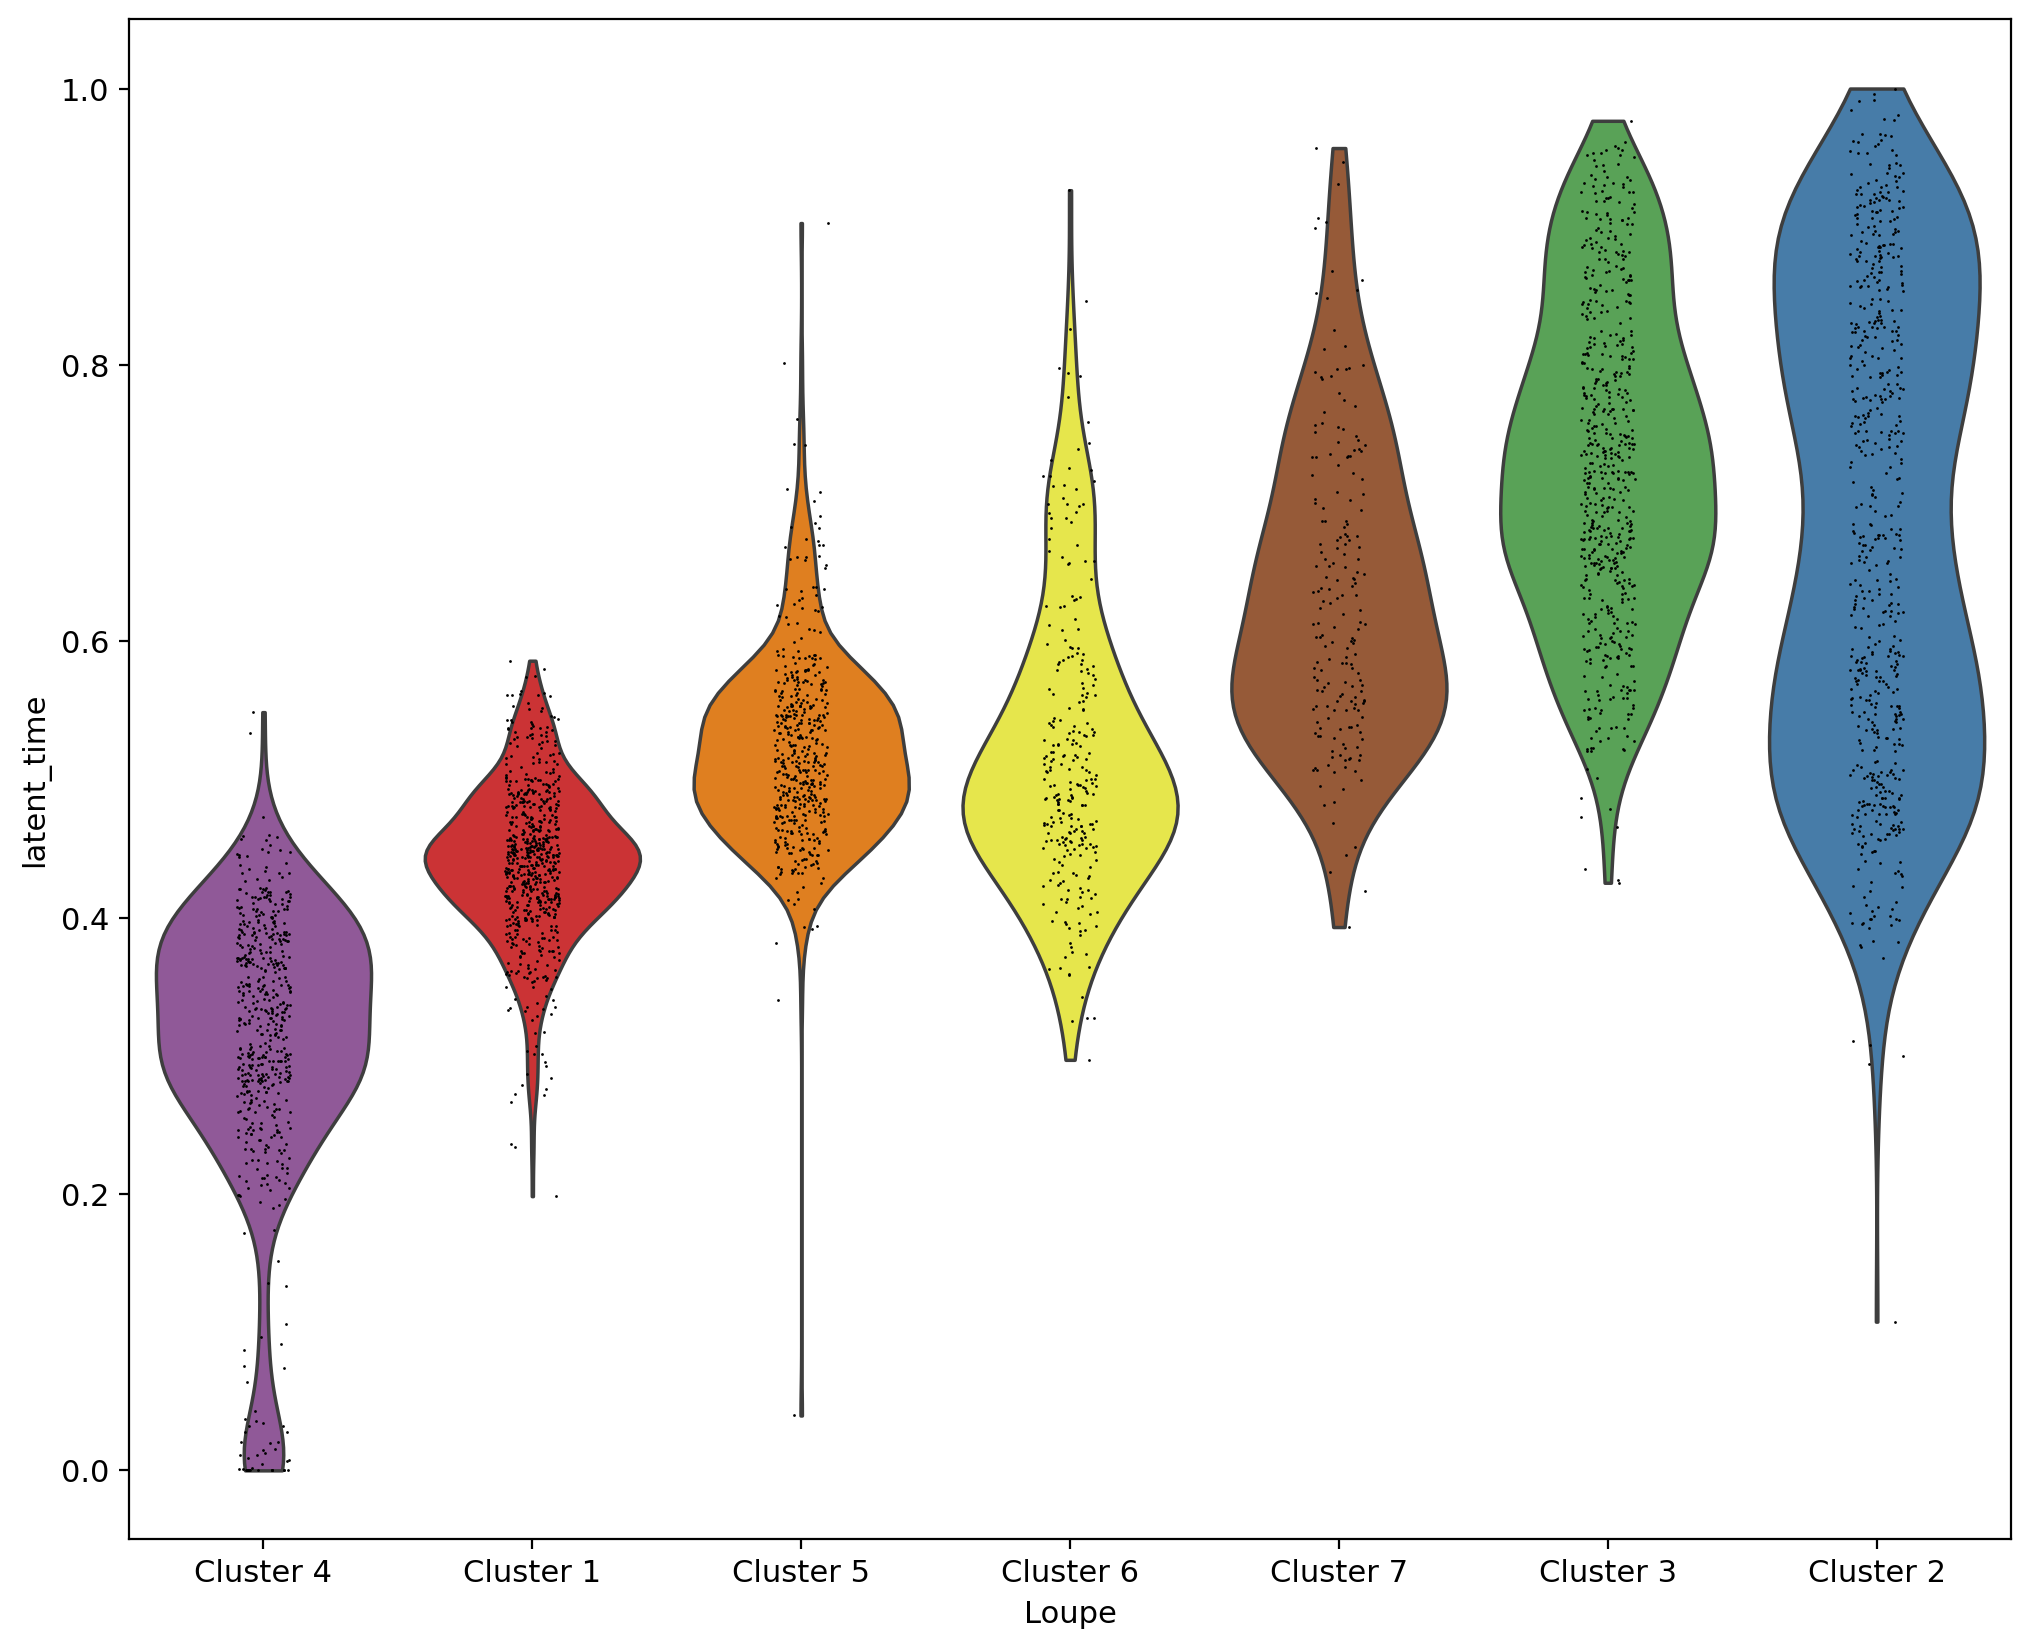

In [21]:
sc.pl.violin(Neutro3p, keys='latent_time',groupby="Loupe",order=["Cluster 4","Cluster 1","Cluster 5","Cluster 6","Cluster 7","Cluster 3","Cluster 2"], save='scVelo-violin-latent_time.png')

For additional information on analysis using this [10x neutrophils dataset](https://www.10xgenomics.com/resources/datasets/whole-blood-rbc-lysis-for-pbmcs-neutrophils-granulocytes-3-3-1-standard), please see this Tech Note, [Neutrophil Analysis in 10x Genomics Single Cell Gene Expression Assays](https://www.10xgenomics.com/support/single-cell-gene-expression/documentation/steps/sample-prep/neutrophil-analysis-in-10-x-genomics-single-cell-gene-expression-assays)